---
title: Variance reduction continued
---

In [210]:
import numpy as np
import matplotlib.pyplot as plt

from queue import PriorityQueue


## Control variates

Let $X \sim N(0, 1)$. Estimate $\mathbb{P}(X > 2)$ using the control variate method. Use the control variate $Y = X * \mathbb{I}(X > 2)$, where $\mathbb{I}$ is the indicator function. Note that we you'll need to calculate $\mathbb{E}[Y]$ on paper.

1. Vary the control parameter $\beta$ as given below. Generate $N = 1000$ samples.
2. Plot the running means of the estimates for each $\beta$ in the same graph.
3. Plot the relative errors (std/mean) as a function of $\beta$.

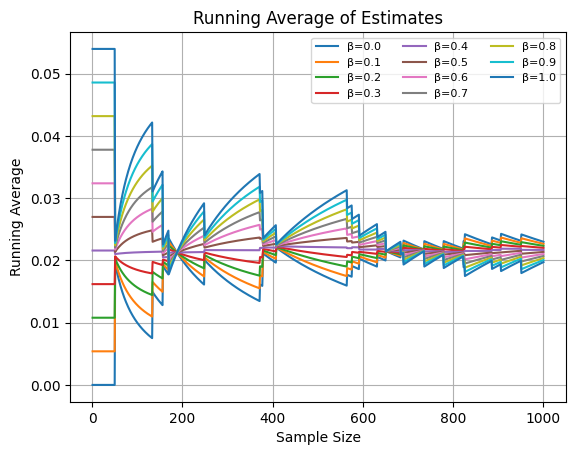

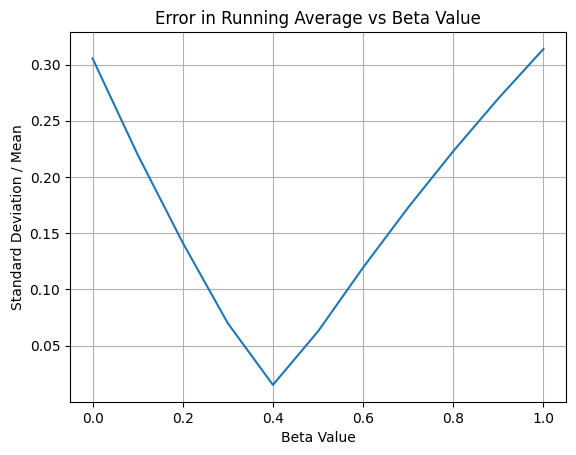

In [211]:


# Parameters
N = 1000
beta_values = np.arange(0, 1.1, 0.1)  # Beta values from 0 to 1 in steps of 0.1

f = lambda x: 1 * (x > 2)
h = lambda x: x * (x > 2)
h0 = np.exp(-2)/np.sqrt(2*np.pi)

x = np.random.normal(0, 1, N)
errors = np.zeros(beta_values.shape)

plt.figure(0)
for i, b in enumerate(beta_values):    
    samples = f(x) - b * (h(x) - h0)
    l_running = np.cumsum(samples) / np.arange(1, N+1)
    plt.plot(np.arange(1, N+1), l_running, label=f'\u03B2={b:.1f}')
    errors[i] = np.std(l_running) / np.mean(l_running)

plt.legend(loc='upper right', fontsize=8, ncol=3)
plt.xlabel('Sample Size')
plt.ylabel('Running Average')
plt.title('Running Average of Estimates')
plt.grid()

plt.figure(1)
plt.plot(beta_values, errors)
plt.xlabel('Beta Value')
plt.ylabel('Standard Deviation / Mean')
plt.title('Error in Running Average vs Beta Value')
plt.grid()



## M/M/n queue

Write an even-driven simulation of an M/M/n queue. As you run the simulation record the waiting time of each customer. Use `queue.PriorityQueue` to implement the event queue.

Remember to generate arrival times and service times ahead of time. This allows us to synchronize the events between two different queues.

In [212]:
class MMnQueue:
    def __init__(self, arrival_rate, service_rate, num_servers, num_customers, seed):
        self.event_queue = PriorityQueue()
        
        self.arrival_times = np.zeros(num_customers) # Arrival times of customers
        self.service_times = np.zeros(num_customers) # Service times of customers
        self.waiting_times = np.zeros(num_customers) # Waiting times of customers
        
        self.arrival_rate = arrival_rate
        self.service_rate = service_rate
        self.num_servers = num_servers
        self.num_customers = num_customers
        self.seed = seed
        
        self.current_time = 0
        self.busy_servers = 0
        self.waiting_customers = []
        self.next_customer_id = 0
        
    def exponential_rvs(self, rate, size=None):
        x = np.random.uniform(0, 1, size=size)
        return -np.log(1 - x) / rate  # Inverse transform sampling for exponential distribution
        
    def prepopulate_queues(self):
        '''
        Prepopulate the arrival and service times queues.
        '''
        np.random.seed(self.seed) # Set random seed for reproducibility and synchronization
        self.arrival_times = self.exponential_rvs(self.arrival_rate, self.num_customers)
        self.service_times = self.exponential_rvs(self.service_rate, self.num_customers)
        
        # Convert arrival times to absolute times (cumulative sum)
        self.arrival_times = np.cumsum(self.arrival_times)
        
    def handle_arrival(self, customer_id, arrival_time):
        """Handle the arrival of a customer"""
        self.current_time = arrival_time
        
        # Schedule the next arrival if there are more customers
        if customer_id + 1 < self.num_customers:
            self.event_queue.put((self.arrival_times[customer_id + 1], 'arrival', customer_id + 1))
        
        # If there's an available server, start service immediately
        if self.busy_servers < self.num_servers:
            self.busy_servers += 1
            service_time = self.service_times[customer_id]
            completion_time = self.current_time + service_time
            self.event_queue.put((completion_time, 'completion', customer_id))
            # No waiting time for this customer
            self.waiting_times[customer_id] = 0
        else:
            # All servers are busy, customer must wait
            self.waiting_customers.append(customer_id)
        
    def handle_completion(self, customer_id, completion_time):
        """Handle the completion of service for a customer"""
        self.current_time = completion_time
        
        # Free up a server
        self.busy_servers -= 1
        
        # If there are waiting customers, start serving the next one
        if self.waiting_customers:
            waiting_customer_id = self.waiting_customers.pop(0)
            self.busy_servers += 1
            
            # Calculate waiting time for this customer
            wait_time = self.current_time - self.arrival_times[waiting_customer_id]
            self.waiting_times[waiting_customer_id] = wait_time
            
            # Schedule service completion
            service_time = self.service_times[waiting_customer_id]
            completion_time = self.current_time + service_time
            self.event_queue.put((completion_time, 'completion', waiting_customer_id))
    
    def run_simulation(self):
        """Run the simulation and return waiting times"""
        # Clear any previous state
        self.event_queue = PriorityQueue()
        self.waiting_customers = []
        self.busy_servers = 0
        self.current_time = 0
        self.next_customer_id = 0
        
        # Prepare arrival and service times
        self.prepopulate_queues()
        
        # Schedule the first arrival
        if self.num_customers > 0:
            self.event_queue.put((self.arrival_times[0], 'arrival', 0))
        
        # Process events until the queue is empty
        while not self.event_queue.empty():
            time, event_type, customer_id = self.event_queue.get()
            
            if event_type == 'arrival':
                self.handle_arrival(customer_id, time)
            elif event_type == 'completion':
                self.handle_completion(customer_id, time)
        
        return self.waiting_times

## Comparing queues

Compare the average waiting times of customers of the M/M/1 queue with the M/M/2 queues with the following parameters:

### For the first queue (M/M/1):
- Arrival rate $\lambda = 3$
- Service rate $\mu = 4$
- Number of customers $N = 100$
- Number of servers $n = 1$

### For the second queue (M/M/2):
- Arrival rate $\lambda = 3$
- Service rate $\mu = 2$
- Number of customers $N = 100$
- Number of servers $n = 2$

### Run two tests:

1. **Synchronized runs**: 
   - Run each queue 1000 times and compute the average waiting times for each queue.
   - For each run, pass the **same random seed** to both queues. (You can randomly generate the 1000 seeds ahead of time.)
   - Compute the **variance of the difference** in the average waiting times between the M/M/1 and M/M/2 queues.

2. **Independent runs**: 
   - Run each queue 1000 times and compute the average waiting times for each queue.
   - For each run, pass **different random seeds** to each queue.
   - Compute the **variance of the difference** in the average waiting times between the M/M/1 and M/M/2 queues.


In [213]:
# synchronized runs
seeds = range(10)
q1_s = [np.mean(MMnQueue(arrival_rate=3, service_rate=4, num_servers=1, num_customers=100, seed=s).run_simulation()) for s in seeds]
q2_s = [np.mean(MMnQueue(arrival_rate=3, service_rate=2, num_servers=2, num_customers=100, seed=s).run_simulation()) for s in seeds]
var_s = np.var(np.array(q1_s) - np.array(q2_s))

# independent runs
q1_i = [np.mean(MMnQueue(arrival_rate=3, service_rate=4, num_servers=1, num_customers=100, seed=s).run_simulation()) for s in range(1000)]
q2_i = [np.mean(MMnQueue(arrival_rate=3, service_rate=2, num_servers=2, num_customers=100, seed=s).run_simulation()) for s in range(1001, 2001)]
var_i = np.var(np.array(q1_i) - np.array(q2_i))

print(f"Variance of synchronized runs: {var_s}")
print(f"Variance of independent runs: {var_i}")


Variance of synchronized runs: 0.003219191042372293
Variance of independent runs: 0.3709510500218679


As expected, the varianace of the synchronized runs is much lower than the variance of independent runs. This is due to the high correlation between the waiting times of the two queues when the arrival and service times are generated using the same random seed. As a result, a positive covariance term is subtracted from the overall variance calculation in the synchronized case.